In [ ]:
# https://www.kaggle.com/code/nitinchoudhary012/car-object-detection
# https://github.com/dmlc/gluon-cv
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,Input
from tensorflow.keras.models import Model,Sequential
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import io
import os
from tensorflow.keras.preprocessing.image import img_to_array,load_img
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model
import random
import imutils

import warnings
warnings.filterwarnings('ignore')

In [ ]:
! pip install -q kaggle

from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                         title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                             DAIGT V2 Train Dataset                          29MB  2023-11-16 01:38:36           2393        219  1.0              
manjitbaishya001/la-crime-data-2010-to-2023                 Los Angeles Crime Data - 2010 to 2023          147MB  2023-12-19 13:20:31            816         24  1.0              
manjitbaishya001/house-prices-2023                          Pakistan House Prices - 2023                     1MB  2023-12-15 18:57:24            823         22  1.0              
muhammadbinimran/housing-price-prediction-data              Housing Pri

In [ ]:
!kaggle datasets download -d sshikamaru/car-object-detection

 96% 108M/112M [00:03<00:00, 40.0MB/s]
100% 112M/112M [00:03<00:00, 30.9MB/s]


In [ ]:
!mkdir -p dataset && cd dataset && unzip /content/car-object-detection.zip

Archive:  /content/car-object-detection.zip
  inflating: data/sample_submission.csv  
  inflating: data/testing_images/vid_5_25100.jpg  
  inflating: data/testing_images/vid_5_25120.jpg  
  inflating: data/testing_images/vid_5_25140.jpg  
  inflating: data/testing_images/vid_5_25160.jpg  
  inflating: data/testing_images/vid_5_25180.jpg  
  inflating: data/testing_images/vid_5_25200.jpg  
  inflating: data/testing_images/vid_5_25220.jpg  
  inflating: data/testing_images/vid_5_25240.jpg  
  inflating: data/testing_images/vid_5_25260.jpg  
  inflating: data/testing_images/vid_5_26320.jpg  
  inflating: data/testing_images/vid_5_26400.jpg  
  inflating: data/testing_images/vid_5_26420.jpg  
  inflating: data/testing_images/vid_5_26560.jpg  
  inflating: data/testing_images/vid_5_26580.jpg  
  inflating: data/testing_images/vid_5_26600.jpg  
  inflating: data/testing_images/vid_5_26620.jpg  
  inflating: data/testing_images/vid_5_26640.jpg  
  inflating: data/testing_images/vid_5_26660.jp

In [ ]:
# import zipfile
# zip_ref = zipfile.ZipFile('/content/data-for-yolo-v3-kernel.zip', 'r')
# zip_ref.extractall('files')
# zip_ref.close()
# import pandas as pd
# # movies=pd.read_csv(/content/files/movies_metadata.csv)
# # ratings=pd.read_csv(‘/content/files/ratings.csv’)

In [ ]:
file = pd.read_csv('/content/dataset/data/train_solution_bounding_boxes (1).csv')
file['label'] = 'car'
print(file)

               image        xmin        ymin        xmax        ymax label
0     vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547   car
1    vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180   car
2    vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180   car
3    vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575   car
4    vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422   car
..               ...         ...         ...         ...         ...   ...
554   vid_4_9860.jpg    0.000000  198.321729   49.235251  236.223284   car
555   vid_4_9880.jpg  329.876184  156.482351  536.664239  250.497895   car
556   vid_4_9900.jpg    0.000000  168.295823  141.797524  239.176652   car
557   vid_4_9960.jpg  487.428988  172.233646  616.917699  228.839864   car
558   vid_4_9980.jpg  221.558631  182.570434  348.585579  238.192196   car

[559 rows x 6 columns]


In [ ]:
file['image'].unique().shape

(355,)

Photo shape: (380, 676, 3)
Name,xmin,ymin,xmax,ymax: ['vid_4_1000.jpg' 281.2590449 187.0350708 327.7279305 223.225547 'car']


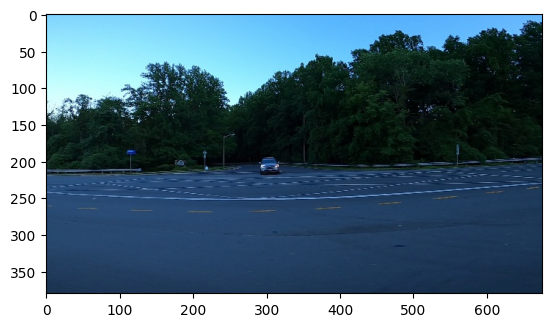

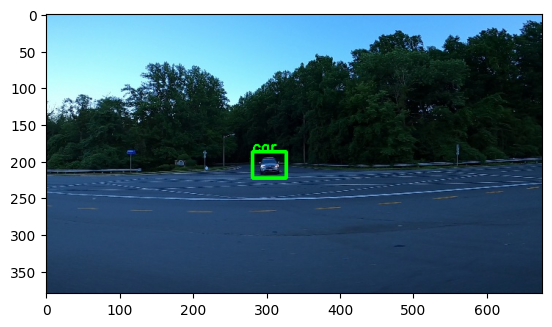

In [ ]:
for i in file.values:
  photo=plt.imread(f'/content/dataset/data/training_images/{i[0]}')
  plt.imshow(photo)
  print('Photo shape:',photo.shape)
  print('Name,xmin,ymin,xmax,ymax:',i)
  pt1=(int(i[1]),int(i[2]))
  pt2=(int(i[3]),int(i[4]))
  color=(0,255, 0)
  thickness = 3
  cv2.putText(photo, 'car', (int(i[1]), int(i[2])), cv2.FONT_HERSHEY_SIMPLEX,0.65, (0, 255, 0), 2)
  cv2.rectangle(photo,pt1,pt2, color, thickness)
  plt.figure()
  plt.imshow(photo)
  break

In [ ]:
data=[]
target=[]
filename=[]
images_folder_path="/content/dataset/data/training_images"

In [ ]:
for index,rows in file.iterrows():

    filen,start_x,start_y,end_x,end_y,label=rows["image"],rows["xmin"],rows["ymin"],rows["xmax"],rows["ymax"],rows['label']

    filename.append(filen)

    image_path=images_folder_path+str('/')+filen
#     print(image_path)
    image=cv2.imread(image_path)
#     print(image.shape)

    h,w,_=image.shape
#     assert not isinstance(image,type(None)), 'image not found'

    start_x=start_x/w
    start_y=start_y/h
    end_x=end_x/w
    end_y=end_y/h

    image=load_img(image_path,target_size=(224,224))
    image=img_to_array(image)

    data.append(image)
    target.append((start_x,start_y,end_x,end_y))

In [ ]:
data.shape

(559, 224, 224, 3)

In [ ]:
data=np.array(data,dtype="float32")/255.0
targets=np.array(target,dtype="float32")


train_images,validation_images,train_targets,validation_targets=train_test_split(data,targets,test_size=0.1,random_state=2022)

In [ ]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

class LRFinder(Callback):
    """
    Up-to date version: https://github.com/WittmannF/LRFinder
    Example of usage:
        from keras.models import Sequential
        from keras.layers import Flatten, Dense
        from keras.datasets import fashion_mnist
        !git clone https://github.com/WittmannF/LRFinder.git
        from LRFinder.keras_callback import LRFinder
        # 1. Input Data
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
        mean, std = X_train.mean(), X_train.std()
        X_train, X_test = (X_train-mean)/std, (X_test-mean)/std
        # 2. Define and Compile Model
        model = Sequential([Flatten(),
                            Dense(512, activation='relu'),
                            Dense(10, activation='softmax')])
        model.compile(loss='sparse_categorical_crossentropy', \
                      metrics=['accuracy'], optimizer='sgd')
        # 3. Fit using Callback
        lr_finder = LRFinder(min_lr=1e-4, max_lr=1)
        model.fit(X_train, y_train, batch_size=128, callbacks=[lr_finder], epochs=2)
    """
    def __init__(self, min_lr, max_lr, mom=0.9, stop_multiplier=None,
                 reload_weights=True, batches_lr_update=5):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        self.reload_weights = reload_weights
        self.batches_lr_update = batches_lr_update
        if stop_multiplier is None:
            self.stop_multiplier = -20*self.mom/3 + 10 # 4 if mom=0.9
                                                       # 10 if mom=0
        else:
            self.stop_multiplier = stop_multiplier

    def on_train_begin(self, logs={}):
        p = self.params
        try:
            n_iterations = p['epochs']*p['samples']//p['batch_size']
        except:
            n_iterations = p['steps']*p['epochs']

        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations//self.batches_lr_update+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        if self.reload_weights:
            self.model.save_weights('tmp.hdf5')


    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')

        if self.iteration!=0: # Make loss smoother using momentum
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)

        if self.iteration==0 or loss < self.best_loss:
                self.best_loss = loss

        if self.iteration%self.batches_lr_update==0: # Evaluate each lr over 5 epochs

            if self.reload_weights:
                self.model.load_weights('tmp.hdf5')

            lr = self.learning_rates[self.iteration//self.batches_lr_update]
            K.set_value(self.model.optimizer.lr, lr)

            self.losses.append(loss)

        if loss > self.best_loss*self.stop_multiplier: # Stop criteria
            self.model.stop_training = True

        self.iteration += 1

    def on_train_end(self, logs=None):
        if self.reload_weights:
                self.model.load_weights('tmp.hdf5')

        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()

In [ ]:
checkpoint_filepath = 'best_weights.hdf5'

earlyStop = EarlyStopping(monitor='val_accuracy', patience=15,
                        verbose=1, mode='max',restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_weights_only=False,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True)
learningrate = ReduceLROnPlateau(monitor='val_accuracy',
                                          mode='max',
                                          min_delta=0.03, patience=3,
                                          factor=.5,
                                          min_lr=0.00001, verbose=1)
lr_finder = LRFinder(min_lr=1e-4, max_lr=1)
callbacks = [earlyStop, checkpoint, lr_finder]

In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

input =tensorflow.keras.Input(shape=(224,224,3))
layer_1 = Conv2D(64,(3,3),activation="relu",padding="same")(input)
layer_2 = Conv2D(64,(3,3),activation="relu",padding="same")(layer_1)
layer_3 = MaxPool2D(2,2)(layer_2)
layer_4 = Conv2D(128,(3,3),activation="relu",padding="same")(layer_3)
layer_5 = Conv2D(128,(3,3),activation="relu",padding="same")(layer_4)
layer_6 = MaxPool2D(2,2)(layer_5)
layer_7 = Conv2D(256,(3,3),activation="relu",padding="same")(layer_6)
layer_8 = Conv2D(256,(3,3),activation="relu",padding="same")(layer_7)
layer_9 = MaxPool2D(2,2)(layer_8)
layer_10 = Conv2D(512,(3,3),activation="relu",padding="same")(layer_9)
layer_11 = Conv2D(512,(3,3),activation="relu",padding="same")(layer_10)
layer_12 = Flatten()(layer_11)
layer_13 = Dense(256,activation="relu")(layer_12)
layer_14 = Dense(128,activation="relu")(layer_13)
layer_15 = Dense(64,activation="relu")(layer_14)
layer_16 = Dense(32,activation="relu")(layer_15)
layer_17 = Dense(4,activation="sigmoid")(layer_16)

model = tensorflow.keras.Model(inputs=input, outputs=layer_17, name='OB_model')

opt=Adam(learning_rate=0.0001)
model.compile(loss="mse",optimizer=opt, metrics=['accuracy'])

print(model.summary())

Model: "OB_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 128)     147584    
                                                          

In [ ]:
# from tensorflow.keras import backend as K
# def iou_coeff(ytrue, ypred, smooth=100):
#     intersection = K.sum(ytrue * ypred)
#     union = K.sum(ytrue + ypred) - intersection
#     return (intersection + smooth)/(union + smooth)

In [ ]:
model=Sequential()
model.add(tensorflow.keras.Input(shape=(224,224,3)))
model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Conv2D(512,(3,3),activation="relu",padding="same"))
model.add(Conv2D(512,(3,3),activation="relu",padding="same"))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(4,activation="sigmoid"))


opt=Adam(learning_rate=0.0001)
model.compile(loss="mse",optimizer=opt, metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

Epoch 1/3
  6/126 [>.............................] - ETA: 32s - loss: 0.0634 - accuracy: 0.3750

126/126 [==============================] - 48s 377ms/step - loss: 0.0606 - accuracy: 0.4851 - val_loss: 0.0547 - val_accuracy: 0.4107
Epoch 2/3
126/126 [==============================] - 34s 267ms/step - loss: 0.1914 - accuracy: 0.1829 - val_loss: 0.3788 - val_accuracy: 0.0000e+00
Epoch 3/3
126/126 [==============================] - 4s 34ms/step - loss: 0.3318 - accuracy: 0.0714 - val_loss: 0.0547 - val_accuracy: 0.4107


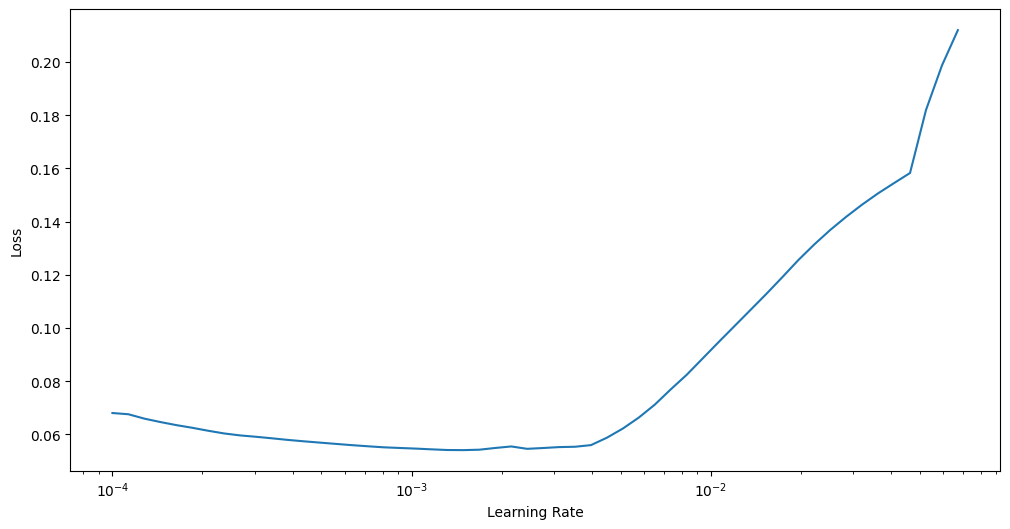

In [ ]:
history=model.fit(train_images,train_targets,validation_data=(validation_images,validation_targets),batch_size=4,epochs=3,callbacks=callbacks,verbose=1)

In [ ]:
history.history['val']

In [ ]:
model.save('object_detect.hdf5')

In [ ]:
model = load_model('best_weights.hdf5')

In [ ]:
from collections import namedtuple
# define the `Detection` object
Detection = namedtuple("Detection", ["image_path", "gt", "pred"])

In [ ]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [ ]:
def bbox(path):
    test_image=load_img(path,target_size=(224,224))
    test_image=np.array(test_image)/255
    test_image=np.expand_dims(test_image,axis=0)

    prediction=model.predict(test_image)[0]
    (startX,startY,endX,endY)=prediction

    test_img=cv2.imread(path)
#     test_img=imutils.resize(test_img,width=600)
    (h,w)=test_img.shape[:2]

    startX=int(startX*w)
    startY=int(startY*h)
    endX=int(endX*w)
    endY=int(endY*h)
    return [startX,startY,endX,endY]

bbox("/content/dataset/data/training_images/vid_4_10000.jpg")

1/1 [==============================] - 0s 128ms/step


[37, 183, 88, 230]

In [ ]:
[int(x) for x in file.iloc[0,1:-1].tolist()]

[281, 187, 327, 223]

In [ ]:
examples = [
	Detection("/content/dataset/data/training_images/vid_4_1000.jpg", [int(x) for x in file.iloc[0,1:-1].tolist()], bbox("/content/dataset/data/training_images/vid_4_1000.jpg")),
	Detection("/content/dataset/data/training_images/vid_4_10000.jpg", [int(x) for x in file.iloc[1,1:-1].tolist()], bbox("/content/dataset/data/training_images/vid_4_10000.jpg"))]

1/1 [==============================] - 0s 19ms/step


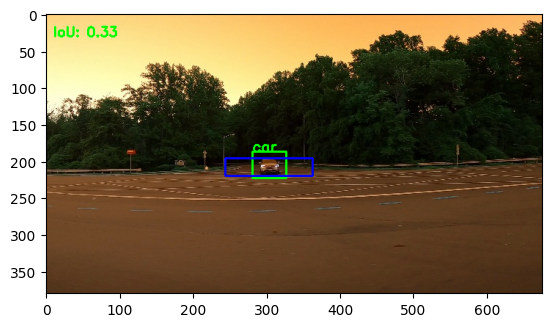

In [ ]:
detection=examples[0]
# load the image
image = cv2.imread(detection.image_path)
# draw the ground-truth bounding box along with the predicted
# bounding box
cv2.rectangle(image, tuple(detection.gt[:2]),
  tuple(detection.gt[2:]), (0, 255, 0), 2)
cv2.putText(image, 'car', (detection.gt[0], detection.gt[1]), cv2.FONT_HERSHEY_SIMPLEX,0.65, (0, 255, 0), 2)
cv2.rectangle(image, tuple(detection.pred[:2]),
  tuple(detection.pred[2:]), (0, 0, 255), 2)
# compute the intersection over union and display it
iou = bb_intersection_over_union(detection.gt, detection.pred)
cv2.putText(image, "IoU: {:.2f}".format(iou), (10, 30),
  cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
# print("{}: {:.4f}".format(detection.image_path, iou))
# show the output image
plt.imshow(image);

1/1 [==============================] - 0s 29ms/step


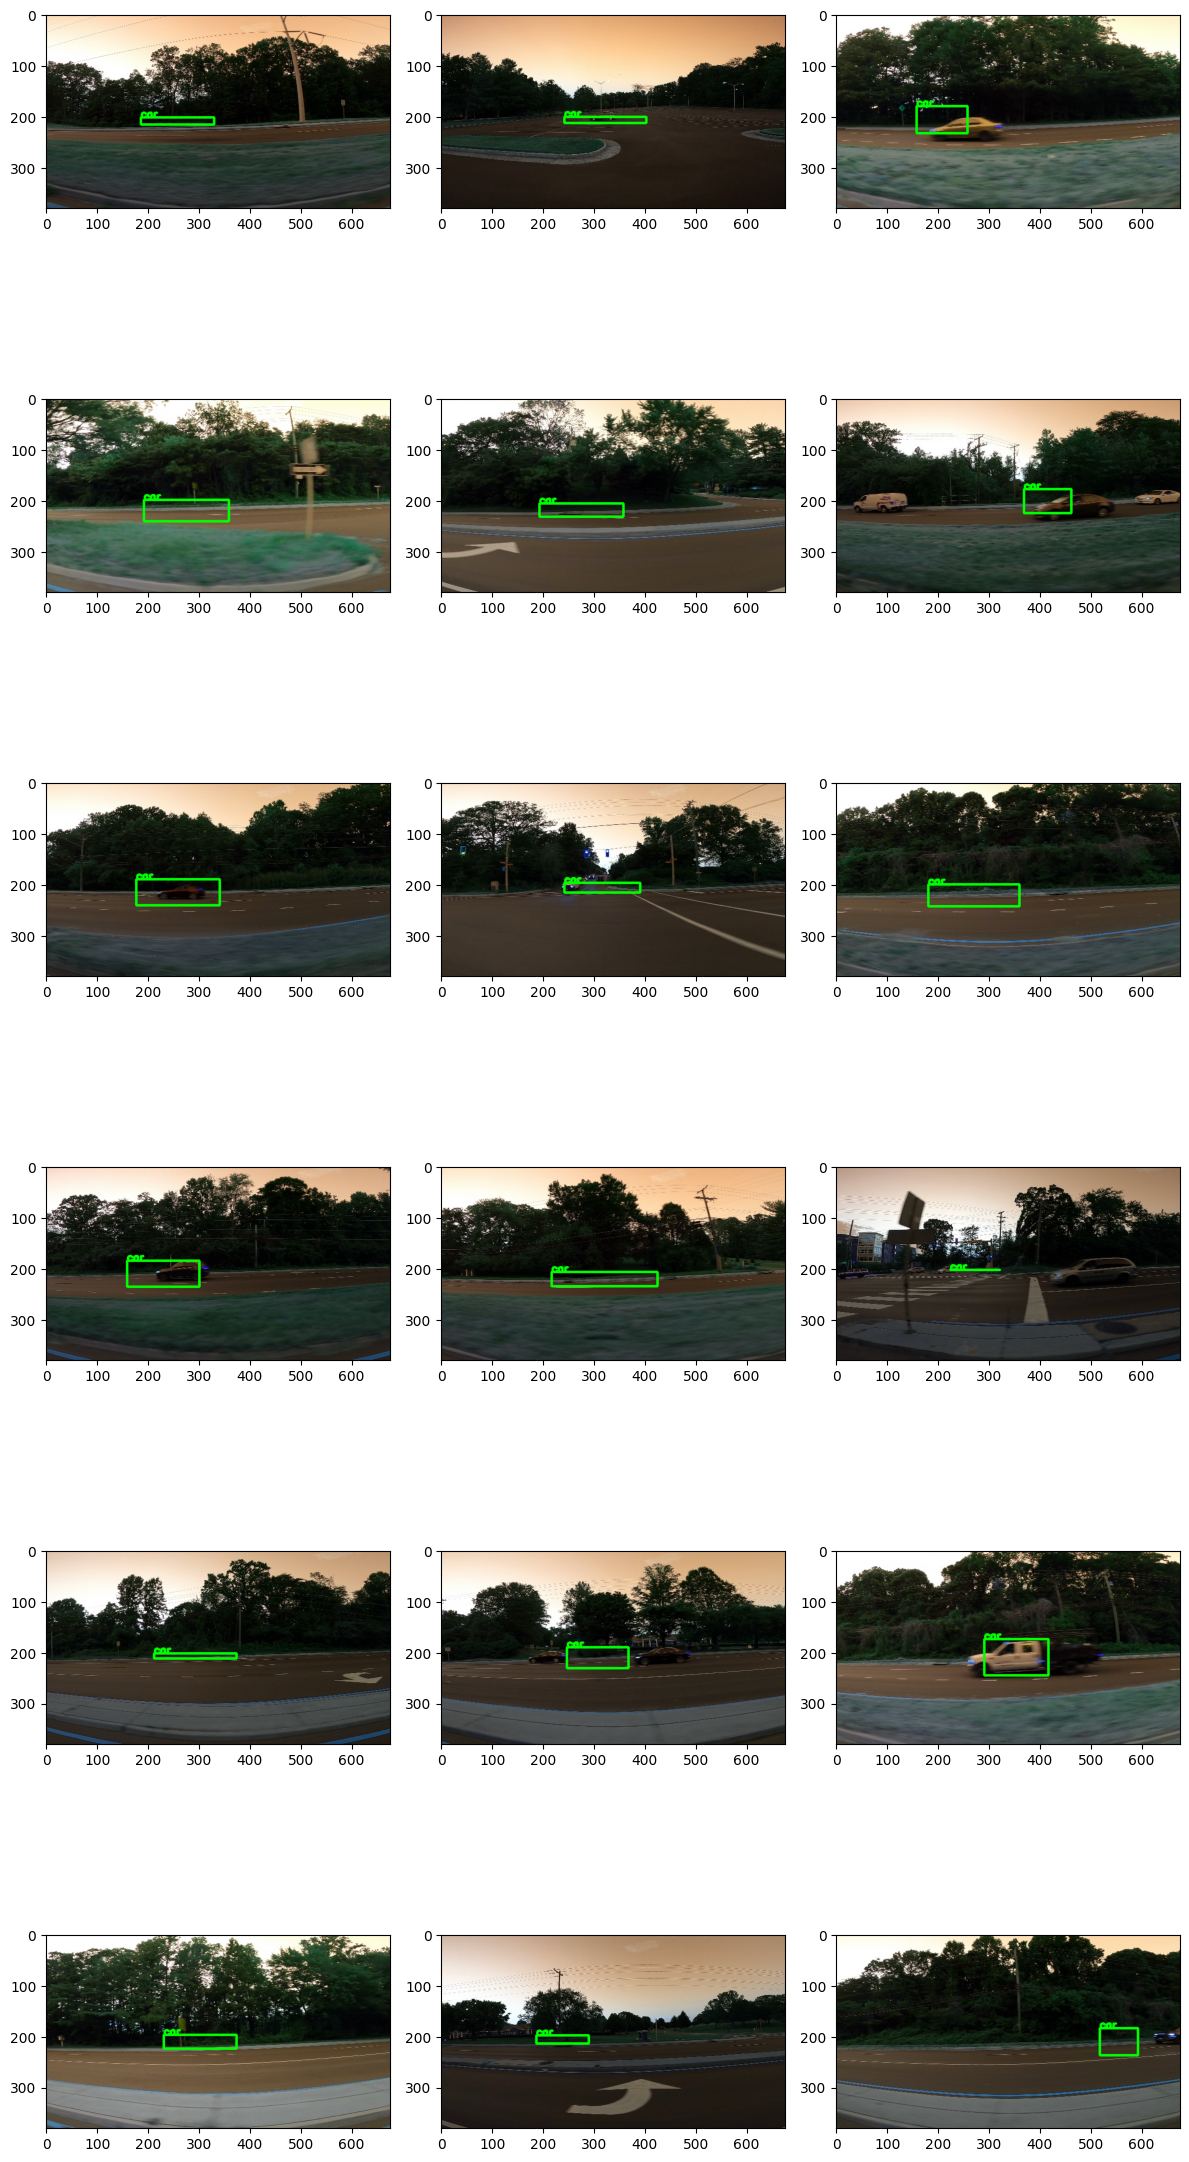

[INFO] cleaning up...


In [ ]:
import cv2

import glob


plt.figure(figsize=(12, 24))
test_image_path = glob.glob('/content/dataset/data/testing_images' + '/*.jpg')
# print(test_image_path)
for index,path in enumerate(test_image_path[0:18]):
    test_image=load_img(path,target_size=(224,224))
    test_image=np.array(test_image)/255
    test_image=np.expand_dims(test_image,axis=0)

    prediction=model.predict(test_image)[0]
    (startX,startY,endX,endY)=prediction

    test_img=cv2.imread(path)
#     test_img=imutils.resize(test_img,width=600)
    (h,w)=test_img.shape[:2]

    startX=int(startX*w)
    startY=int(startY*h)
    endX=int(endX*w)
    endY=int(endY*h)
    cv2.putText(test_img, 'car', (startX,startY), cv2.FONT_HERSHEY_SIMPLEX,0.65, (0, 255, 0), 3)
    cv2.rectangle(test_img,(startX,startY),(endX,endY),(0,255,0),3)
    plt.subplot(6, 3, index+1)
    plt.imshow(test_img)

    # outputPath = os.getcwd()
    # outputFile = path[:-4]+'_detected.jpg'
    # cv2.imwrite(os.path.join(outputPath , outputFile),test_img)

plt.tight_layout()
plt.show()
print("[INFO] cleaning up...")

### Feature extraction

In [ ]:
model.layers[0].output

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_7')>

In [ ]:
model.layers[-5:-1]

In [ ]:
model.layers[0].output

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_7')>

In [ ]:
inp = model.layers[0]
outputs = [layer for layer in model.layers[-5:-1]]   # all layer outputs
models = [tensorflow.keras.Model(inputs=inp.output, outputs=output.output) for output in outputs]    # evaluation functions

In [ ]:
layer_outs = [model.predict(train_images) for model in models]

16/16 [==============================] - 1s 91ms/step


In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate,KFold,cross_val_predict
from sklearn.metrics import mean_squared_error
regr = MultiOutputRegressor(Ridge(random_state=123)).fit(layer_outs[1], train_targets)
cross_val_predict(regr,layer_outs[1], train_targets,cv=KFold(5))

array([[0.43038788, 0.49656174, 0.56917655, 0.58858496],
       [0.5354001 , 0.4800785 , 0.6134857 , 0.5704065 ],
       [0.7531867 , 0.46637255, 0.84261686, 0.56903356],
       ...,
       [0.3155375 , 0.49940956, 0.45770097, 0.60677284],
       [0.43464065, 0.49497816, 0.64191085, 0.6300603 ],
       [0.3781168 , 0.49702346, 0.51705456, 0.6149502 ]], dtype=float32)

In [ ]:
# import tensorflow as tf
# with tf.device('/device:GPU:0'):
#   models[0].predict(train_images)

In [ ]:
# from tensorflow.python.client import device_lib

# device_lib.list_local_devices()

### Con Data Augmentation

In [ ]:
# import numpy as np

# np.setdiff1d(df_train.X.values,'/content/dataset/data/training_images/'+file.image.values)

- rotation_range es un valor en grados (0–180) que indica el rango dentro del cual se pueden rotar imágenes al azar.

- width_shifty height_shift son rangos (como una fracción del ancho y la altura total) dentro de los cuales se pueden trasladar las imágenes al azar verticalmente u horizontalmente.

- shear_range sirve para aplicar transformaciones de corte al azar.
zoom_rangesirve para aplicar zoomaleatorio dentro de las imágenes.

- horizontal_flip es para voltear aleatoriamente la mitad de las imágenes horizontalmente (en nuestro caso de estudio no tiene sentido voltear verticalmente las imágenes).

- fill_mode es la estrategia utilizada para rellenar los píxeles recién creados que pueden aparecer después de una de las transformaciones anteriores.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator rotation
aug = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [ ]:
image_path='/content/dataset/data/training_images/vid_4_1000.jpg'

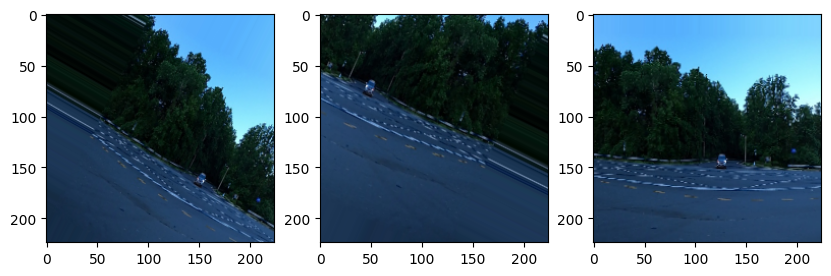

In [ ]:
#Loads in image path
img = load_img(image_path, target_size= (224,224))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
#Uses ImageDataGenerator to flip the images
#Creates our batch of one image
pic = aug.flow(img_tensor, batch_size =1)
plt.figure(figsize=(10,8))
#Plots our figures
for i in range(1,4):
  plt.subplot(1, 3, i)
  batch = pic.next()
  image_ = batch[0].astype('uint8')
  plt.imshow(image_)
plt.show()

In [ ]:
checkpoint_filepath = 'best_weights.hdf5'

earlyStop = EarlyStopping(monitor='val_accuracy', patience=15,
                        verbose=1, mode='max',restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_weights_only=False,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True)
learningrate = ReduceLROnPlateau(monitor='val_accuracy',
                                          mode='max',
                                          min_delta=0.03, patience=3,
                                          factor=.5,
                                          min_lr=0.00001, verbose=1)

callbacks = [earlyStop, checkpoint, learningrate]

In [ ]:
model=Sequential()
model.add(Conv2D(64,(3,3),activation="relu",padding="same",input_shape=(224,224,3)))
model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Conv2D(512,(3,3),activation="relu",padding="same"))
model.add(Conv2D(512,(3,3),activation="relu",padding="same"))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(4,activation="sigmoid"))


opt=Adam(learning_rate=0.0001)
model.compile(loss="mse",optimizer=opt, metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_25 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_27 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 56, 56, 128)       0         
 ng2D)                                                

In [ ]:
model.fit(aug.flow(train_images,train_targets),validation_data=(validation_images,validation_targets),batch_size=16,epochs=50,callbacks=callbacks,verbose=1)

Epoch 1/50
16/16 [==============================] - 54s 2s/step - loss: 0.0508 - accuracy: 0.5368 - val_loss: 0.0499 - val_accuracy: 0.6429 - lr: 1.0000e-04
Epoch 2/50
 8/16 [==============>...............] - ETA: 4s - loss: 0.0465 - accuracy: 0.5870

KeyboardInterrupt: ignored

### Importando modelo VGG16

In [ ]:
import tensorflow as tf

base_model=tf.keras.applications.VGG16(include_top=False,input_shape=(224,224,3),weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable=False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model=tf.keras.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(4,activation="sigmoid"))
opt=Adam(learning_rate=0.0001)
model.compile(loss="mse",optimizer=opt, metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_20 (Dense)            (None, 256)               6422784   
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 4)                

In [ ]:
model.fit(train_images,train_targets,validation_data=(validation_images,validation_targets),batch_size=16,epochs=50,callbacks=callbacks,verbose=1)

Epoch 1/50
32/32 [==============================] - 4s 113ms/step - loss: 0.0480 - accuracy: 0.5606 - val_loss: 0.0442 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 2/50
32/32 [==============================] - 3s 100ms/step - loss: 0.0392 - accuracy: 0.7038 - val_loss: 0.0398 - val_accuracy: 0.7321 - lr: 1.0000e-04
Epoch 3/50
32/32 [==============================] - 3s 100ms/step - loss: 0.0347 - accuracy: 0.7376 - val_loss: 0.0347 - val_accuracy: 0.8036 - lr: 1.0000e-04
Epoch 4/50
32/32 [==============================] - 3s 100ms/step - loss: 0.0315 - accuracy: 0.7535 - val_loss: 0.0341 - val_accuracy: 0.8036 - lr: 1.0000e-04
Epoch 5/50
32/32 [==============================] - 3s 100ms/step - loss: 0.0319 - accuracy: 0.7376 - val_loss: 0.0339 - val_accuracy: 0.7857 - lr: 1.0000e-04
Epoch 6/50
32/32 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.7634
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
32/32 [============================

In [ ]:
# for i,layer in enumerate(base_model.layers):
#   print(i,layer.name,'-',layer.trainable)

1/1 [==============================] - 0s 17ms/step


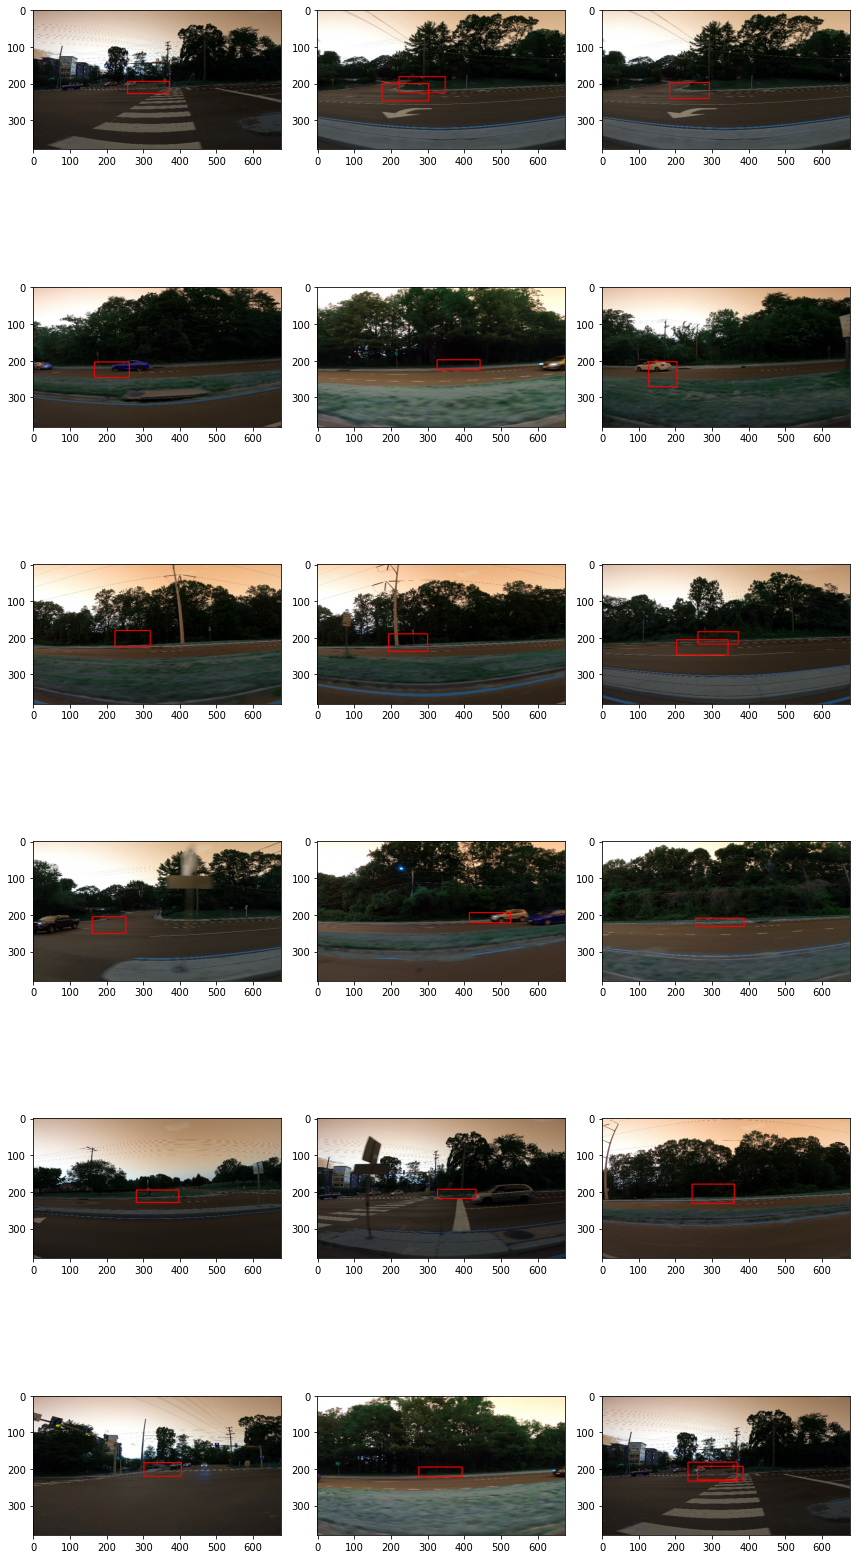

[INFO] cleaning up...


In [ ]:
plt.figure(figsize=(12, 24))
test_image_path = glob.glob('/content/dataset/data/testing_images' + '/*.jpg')
# print(test_image_path)
for index,path in enumerate(test_image_path[0:18]):
    test_image=load_img(path,target_size=(224,224))
    test_image=np.array(test_image)/255
    test_image=np.expand_dims(test_image,axis=0)

    prediction=model.predict(test_image)[0]
    (startX,startY,endX,endY)=prediction

    test_img=cv2.imread(path)
#     test_img=imutils.resize(test_img,width=600)
    (h,w)=test_img.shape[:2]

    startX=int(startX*w)
    startY=int(startY*h)
    endX=int(endX*w)
    endY=int(endY*h)

    cv2.rectangle(test_img,(startX,startY),(endX,endY),(255,0,0),2)
    plt.subplot(6, 3, index+1)
    plt.imshow(test_img)

    # outputPath = os.getcwd()
    # outputFile = path[:-4]+'_detected.jpg'
    # cv2.imwrite(os.path.join(outputPath , outputFile),test_img)

plt.tight_layout()
plt.show()
print("[INFO] cleaning up...")

### Importando faster_rcnn tensorflow hub and fine tunning

In [ ]:
import tensorflow_hub as hub

module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

In [ ]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [ ]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

In [ ]:
random.sample(range(1, 100), 5)

[48, 34, 90, 88, 23]

In [ ]:
random.choice(random.sample(range(1, 100), 5))

8

Found 100 objects.
Inference time:  1.328981876373291


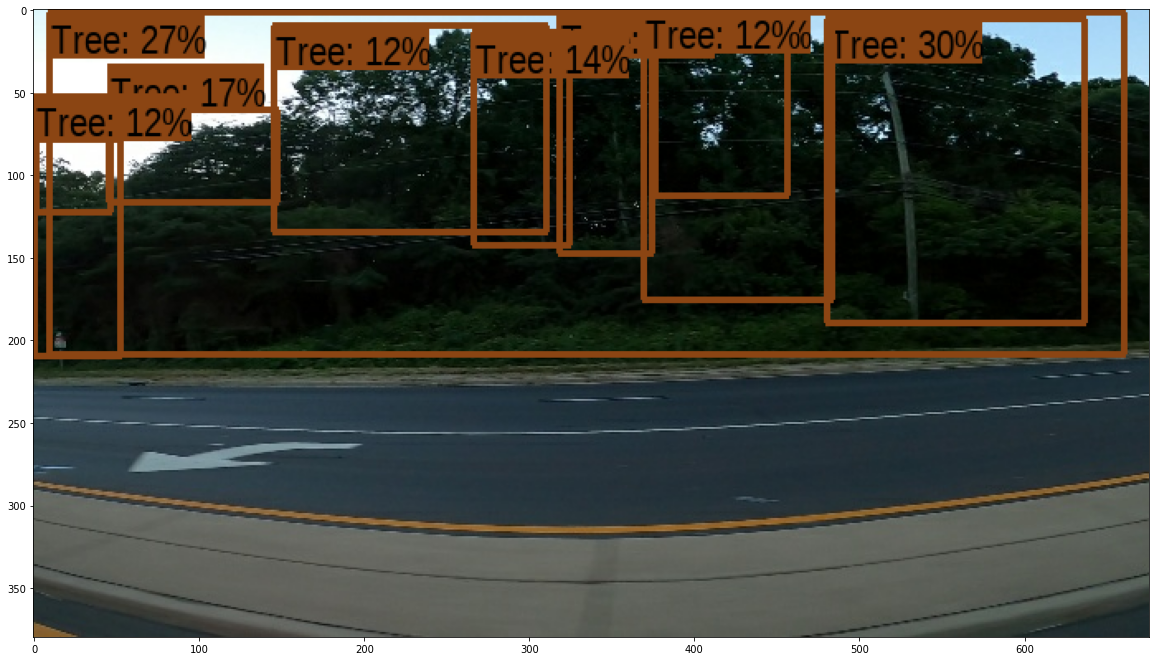

In [ ]:
import glob
import time
import tensorflow as tf
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

idxs=[48, 34, 90, 88, 23,100,25,92]
j=np.random.choice(idxs)
test_image_path = glob.glob('/content/dataset/data/testing_images' + '/*.jpg')
run_detector(detector, test_image_path[j])

In [ ]:
fastrcnn= "https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/4"

feature_extractor_model = fastrcnn

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(256,'relu'),tf.keras.layers.Dense(64,'relu'),
  tf.keras.layers.Dense(32,'relu'),tf.keras.layers.Dense(4,'sigmoid'),
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1024)              3228864   
                                                                 
 dense_25 (Dense)            (None, 256)               262400    
                                                                 
 dense_26 (Dense)            (None, 64)                16448     
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 dense_28 (Dense)            (None, 4)                 132       
                                                                 
Total params: 3509924 (13.39 MB)
Trainable params: 281060 (1.07 MB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________


In [ ]:
opt=Adam(learning_rate=0.0001)
model.compile(loss="mse",optimizer=opt, metrics=['accuracy'])

In [ ]:
checkpoint_filepath = 'best_weights_fastrcnn.hdf5'

earlyStop = EarlyStopping(monitor='val_accuracy', patience=15,
                        verbose=1, mode='max',restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_weights_only=False,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True)
learningrate = ReduceLROnPlateau(monitor='val_accuracy',
                                          mode='max',
                                          min_delta=0.03, patience=3,
                                          factor=.5,
                                          min_lr=0.00001, verbose=1)

callbacks = [earlyStop, checkpoint, learningrate]

In [ ]:
model.fit(train_images,train_targets,validation_data=(validation_images,validation_targets),batch_size=16,epochs=50,callbacks=callbacks,verbose=1)

Epoch 1/50
32/32 [==============================] - 6s 88ms/step - loss: 0.0548 - accuracy: 0.4513 - val_loss: 0.0523 - val_accuracy: 0.4821 - lr: 1.0000e-04
Epoch 2/50
32/32 [==============================] - 1s 34ms/step - loss: 0.0477 - accuracy: 0.5706 - val_loss: 0.0507 - val_accuracy: 0.5893 - lr: 1.0000e-04
Epoch 3/50
32/32 [==============================] - 1s 30ms/step - loss: 0.0454 - accuracy: 0.5845 - val_loss: 0.0492 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 4/50
32/32 [==============================] - 1s 27ms/step - loss: 0.0437 - accuracy: 0.6044 - val_loss: 0.0502 - val_accuracy: 0.6071 - lr: 1.0000e-04
Epoch 5/50
32/32 [==============================] - 1s 27ms/step - loss: 0.0421 - accuracy: 0.6143 - val_loss: 0.0494 - val_accuracy: 0.6071 - lr: 1.0000e-04
Epoch 6/50
31/32 [============================>.] - ETA: 0s - loss: 0.0404 - accuracy: 0.6552
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
32/32 [==============================] -

1/1 [==============================] - 0s 19ms/step


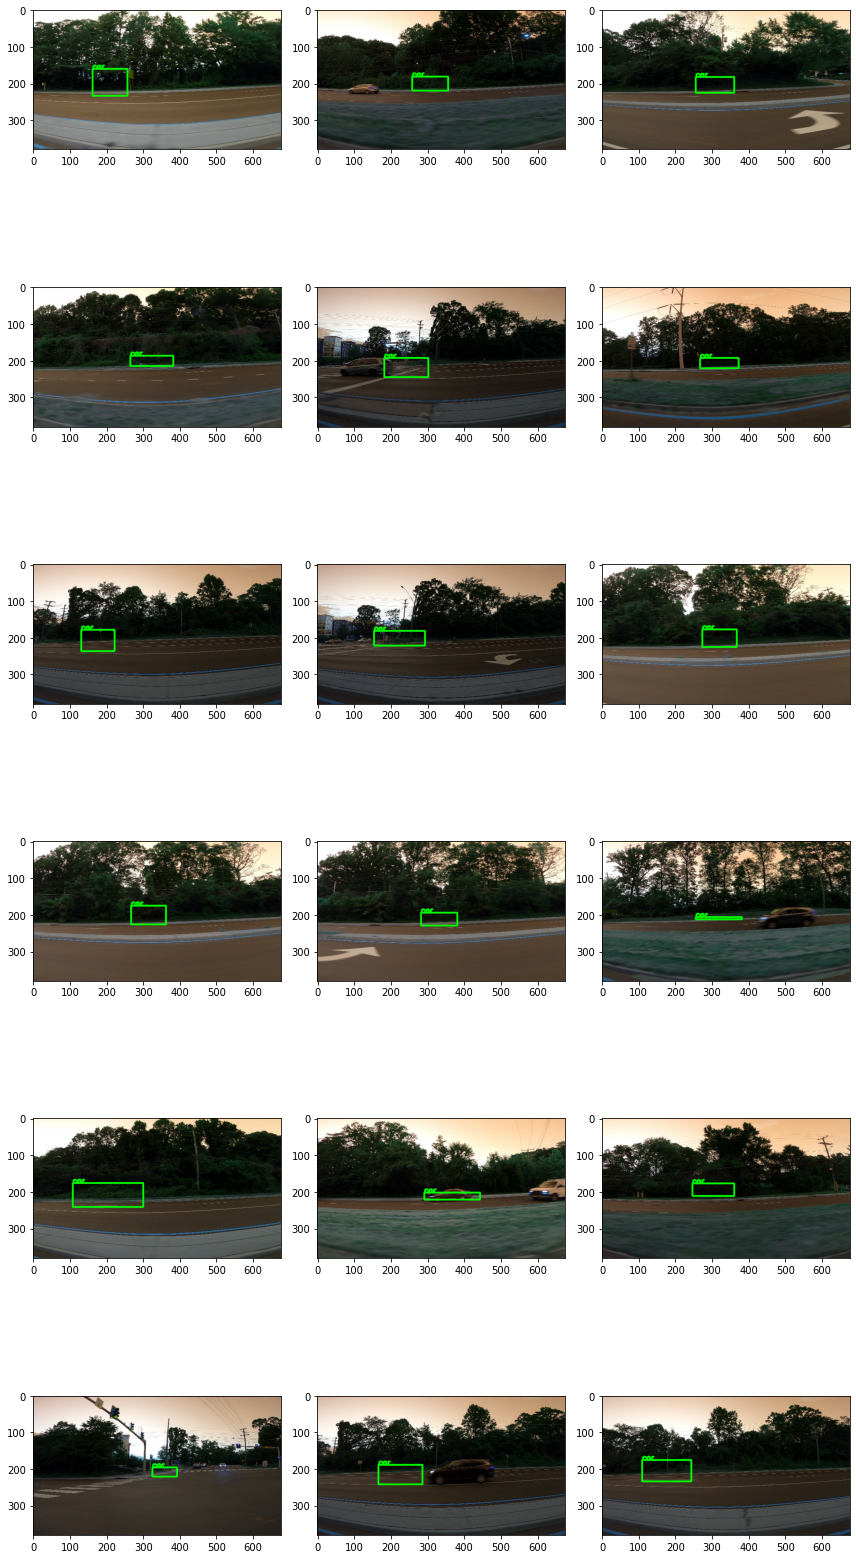

[INFO] cleaning up...


In [ ]:
import cv2

import glob


plt.figure(figsize=(12, 24))
test_image_path = glob.glob('/content/dataset/data/testing_images' + '/*.jpg')
# print(test_image_path)
for index,path in enumerate(test_image_path[0:18]):
    test_image=load_img(path,target_size=(224,224))
    test_image=np.array(test_image)/255
    test_image=np.expand_dims(test_image,axis=0)

    prediction=model.predict(test_image)[0]
    (startX,startY,endX,endY)=prediction

    test_img=cv2.imread(path)
#     test_img=imutils.resize(test_img,width=600)
    (h,w)=test_img.shape[:2]

    startX=int(startX*w)
    startY=int(startY*h)
    endX=int(endX*w)
    endY=int(endY*h)
    cv2.putText(test_img, 'car', (startX,startY), cv2.FONT_HERSHEY_SIMPLEX,0.65, (0, 255, 0), 3)
    cv2.rectangle(test_img,(startX,startY),(endX,endY),(0,255,0),3)
    plt.subplot(6, 3, index+1)
    plt.imshow(test_img)

    # outputPath = os.getcwd()
    # outputFile = path[:-4]+'_detected.jpg'
    # cv2.imwrite(os.path.join(outputPath , outputFile),test_img)

plt.tight_layout()
plt.show()
print("[INFO] cleaning up...")